In [5]:
import numpy as np
import torch
import time
import pickle
torch.set_num_threads(1)
import time

# def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[2., 1.], linspace=1000, noise=0.03, seed=5):
#     nobs = days
#     step_size = 1. / (linspace * obs_per_day)
#     state_ls = np.ones((days * linspace * obs_per_day, 2))
#     state_ls[0] = state0.copy()
#     for i in range(1, linspace * days * obs_per_day):
#         index = i - 1
#         state_ls[i][0] = state_ls[i - 1][0] + step_size * (
#                     alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
#         state_ls[i][1] = state_ls[i - 1][1] + step_size * (
#                     delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
#     states = state_ls[::linspace]
#     np.random.seed(seed)
#     states *= np.random.normal(1, noise, states.shape)
#     return np.log(states)


def RungeKutta_LV(x_init, alpha, beta, delta, gamma, yobs):
    cur_days = yobs.shape[0]
    nsteps = 1
    obs_per_day = 12
    tensor_ls = [[0 for i in range(4)] for j in range(nsteps * cur_days)]
    tensor_ls[0][0] = x_init
    w_ls = [0 for j in range(nsteps * cur_days)]
    w_ls[0] = x_init
    step_size = 1 / (obs_per_day * nsteps)
    for i in range(1, nsteps * cur_days):
        idx = (i - 1) // nsteps
        # k_1
        tensor_ls[i][0] = torch.stack((step_size * (alpha * w_ls[i-1][0] - beta * w_ls[i-1][0] * w_ls[i-1][1]),
                      step_size * (delta * w_ls[i-1][0] * w_ls[i-1][1] - gamma[idx] * w_ls[i-1][1])))

        w_2 = w_ls[i-1] + tensor_ls[i][0] / 2
        tensor_ls[i][1] = torch.stack((step_size * (alpha * w_2[0] - beta * w_2[0] * w_2[1]),
                      step_size * (delta * w_2[0] * w_2[1] - gamma[idx] * w_2[1])))

        w_3 = w_ls[i-1] + tensor_ls[i][1] / 2
        tensor_ls[i][2] = torch.stack((step_size * (alpha * w_3[0] - beta * w_3[0] * w_3[1]),
                      step_size * (delta * w_3[0] * w_3[1] - gamma[idx] * w_3[1])))

        w_4 = w_ls[i-1] + tensor_ls[i][2]
        tensor_ls[i][3] = torch.stack((step_size * (alpha * w_4[0] - beta * w_4[0] * w_4[1]),
                      step_size * (delta * w_4[0] * w_4[1] - gamma[idx] * w_4[1])))

        w_ls[i] = w_ls[i-1] + (tensor_ls[i][0] + 2 * tensor_ls[i][1] + 2 * tensor_ls[i][2] + tensor_ls[i][3]) / 6

    mse = torch.zeros([cur_days,1])
    for i in range(cur_days):
        mse[i] = torch.sum(torch.square(torch.log(w_ls[int(nsteps * i)]) - yobs[i]))
    return torch.sum(mse), w_ls


def RK_solver(cur_days):
    def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[2., 1.], linspace=1000, noise=0.03, seed=5):
        nobs = days
        step_size = 1. / (linspace * obs_per_day)
        state_ls = np.ones((days * linspace * obs_per_day, 2))
        state_ls[0] = state0.copy()
        for i in range(1, linspace * days * obs_per_day):
            index = i - 1
            state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                        alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
            state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                        delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
        states = state_ls[::linspace]
        np.random.seed(seed)
        states *= np.random.normal(1, noise, states.shape)
        return np.log(states)

    
    def construct(vals, occurence_times):
        ls = []
        for idx in range(occurence_times[0]):
            ls.append(vals[0])
        for idx in range(occurence_times[1]):
            ls.append(vals[1])
        return torch.cat(ls, axis=0)# .reshape(-1, vals.shape[1])
    
    discretization=1
    days = 4
    obs_per_day=12
    alpha0 = 0.6
    beta0 = 0.75 
    delta0 = 1. 
    gamma0 = np.concatenate((0.6 * np.ones(30000), 0.6 * np.ones(30000)))
    yobs_np = gen_data(alpha0, beta0, delta0, gamma0, days, obs_per_day) # [:cur_days]
    yobs = torch.tensor(yobs_np)
    occurence_times = np.array([cur_days, 0])               
    for EachIter in range(1):
        t0 = time.time()
        print(EachIter)
        vals_tmp = torch.tensor(np.array([[np.random.uniform()], [np.random.uniform()]]), requires_grad=True)
        x_init = torch.tensor(np.exp(yobs_np[0]), requires_grad = True, dtype = torch.float64)
        alpha = torch.tensor(np.random.uniform(), dtype = torch.float64, requires_grad = True)
        beta = torch.tensor(np.random.uniform(), dtype = torch.float64, requires_grad = True)
        delta = torch.tensor(np.random.uniform(), dtype = torch.float64, requires_grad = True)
        optimizer = torch.optim.Adam([x_init, vals_tmp, alpha, beta, delta], lr=1e-4) 
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
        cur_loss_tmp = np.inf
        loss_trace = []
        for epoch in range(100000):
            optimizer.zero_grad()
            # compute loss function
            new_theta = construct(vals_tmp, occurence_times)
            new_loss, x_latent = RungeKutta_LV(x_init, alpha, beta, delta, new_theta, yobs)
            if epoch % 10 == 0:
                print(epoch, new_loss.item())
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -0.001 and diff < 0.001:
                    break
                cur_loss_tmp = new_loss.item()
                loss_trace.append(cur_loss_tmp)
            new_loss.backward()
            optimizer.step()
            lr_scheduler.step()
        x_ls = x_init.detach().numpy()
        with open('res-' + str(EachIter) +'-'+ str(cur_days) +'.pkl', 'wb') as f:
            res = list([alpha, beta, delta, vals_tmp, x_ls, x_latent, loss_trace, time.time() - t0])
            print(alpha, beta, delta, vals_tmp)
            pickle.dump(res, f)
        occurence_times[0] -= 1
        occurence_times[1] += 1
    

RK_solver(60)

# from multiprocessing import Pool

# if __name__ ==  '__main__': 
#     torch.set_num_threads(1)
#     pool = Pool(processes=50)
#     results = pool.map(RK_solver, range(12))
#     pool.close()
#     pool.join()

0
0 17.071748733520508
10 16.72144317626953
20 16.388994216918945
30 16.07611083984375
40 15.783561706542969
50 15.511356353759766
60 15.258996963500977
70 15.025700569152832
80 14.810527801513672
90 14.612457275390625
100 14.430424690246582
110 14.26333999633789
120 14.110105514526367
130 13.969620704650879
140 13.840798377990723
150 13.722566604614258
160 13.613889694213867
170 13.51376724243164
180 13.421252250671387
190 13.335451126098633
200 13.255535125732422
210 13.180747032165527
220 13.110394477844238
230 13.043868064880371
240 12.980618476867676
250 12.920175552368164
260 12.862130165100098
270 12.806135177612305
280 12.751896858215332
290 12.699173927307129
300 12.647764205932617
310 12.59750747680664
320 12.548267364501953
330 12.499940872192383
340 12.45244312286377
350 12.405704498291016
360 12.359674453735352
370 12.314311027526855
380 12.269580841064453
390 12.225460052490234
400 12.181924819946289
410 12.138959884643555
420 12.096553802490234
430 12.054692268371582
440

In [73]:
with open('res-0-12.pkl', 'rb') as f:
    res = pickle.load(f)
    x_ls = res[:5]
    print(x_ls)
# x_known = torch.cat(x_ls, axis=-1).detach().numpy()

[tensor(0.5990, dtype=torch.float64, requires_grad=True), tensor(0.7510, dtype=torch.float64, requires_grad=True), tensor(1.0010, dtype=torch.float64, requires_grad=True), tensor([[0.5990],
        [0.6000]], dtype=torch.float64, requires_grad=True), array([2.00096059, 1.00099138])]


In [8]:
import matplotlib.pyplot as plt

def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[2., 1.], linspace=1000, noise=0.03, seed=5):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    np.random.seed(seed)
    states *= np.random.normal(1, noise, states.shape)
    return np.log(states)

    
discretization=1
days = 5
obs_per_day=12
alpha0 = 0.6
beta0 = 0.75 
delta0 = 1. 
gamma0 = np.concatenate((0.6 * np.ones(54000), 0.6 * np.ones(24000)))
yobs_np = gen_data(alpha0, beta0, delta0, gamma0, days, obs_per_day)
x_reconstructed = gen_data(alpha0, beta0, delta0, gamma0, days, obs_per_day)

# plt.subplot(1,2,1)
# plt.scatter(np.arange(0, 12, 1), yobs_np[:, 0], label='obs')
# plt.plot(np.log(x[::2]), label = 'inferred x')
# plt.plot(np.log(x2[::20]))
# plt.legend()
# plt.subplot(1,2,2)
# plt.scatter(np.arange(0, 12, 1), yobs_np[:, 1], label='obs')
# plt.plot(np.log(x[1::2]))
# plt.plot(np.log(x2[1::20]))

In [14]:
import numpy as np
import torch
import scipy
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
from multiprocessing import Pool

%matplotlib inline
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
torch.set_num_threads(1)

def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = theta[0] - theta[1] * np.exp(fox)
    Fdt = theta[2] * np.exp(rabbit) - theta[3]
    return np.stack([Rdt, Fdt], axis=1)

def fOdeDx(theta, x):
    """
    returns ODE derivation of x given theta
    theta: list[4]
    x: array(n, 2)
    return: array(n, 2, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    resultDx = np.zeros(shape=[np.shape(x)[0], 2, 2])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dR
    resultDx[:, 0, 0] = 0
    # (0) / dF
    resultDx[:, 1, 0] =  -theta[1] * np.exp(fox)
    # (1) / dR
    resultDx[:, 0, 1] = theta[2] * np.exp(rabbit)
    # (1) / dF
    resultDx[:, 1, 1] = 0
    return resultDx

def fOdeDtheta(theta, x):
    """
    returns ODE derivation of theta given x
    theta: list[4]
    x: array(n, 2)
    return: array(n, 4, 2)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 4, 2])
    # [:, i, j]: jth equation derivative of the ith theta
    rabbit = x[:, 0]
    fox = x[:, 1]
    # (0) / 0
    resultDtheta[:, 0, 0] = 1.
    # (0) / 1
    resultDtheta[:, 1, 0] = -np.exp(fox)
    # (1) / 2
    resultDtheta[:, 2, 1] = np.exp(rabbit)
    # (1) / 3
    resultDtheta[:, 3, 1] = -1.
    return resultDtheta

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

days = 5
discretization = 1
obs_per_day = 12 
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
param_names = ['alpha', 'beta', 'delta', 'gamma']
is_time_varying=[False, False, False, True] 
use_trajectory='inferred'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [15001, 200000, 15000, 200000]
    
yobs = yobs_np
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
    each_pycov = dict(
        Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
        Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
        mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
    )
    CovAllDimensionsPyList.append(each_pycov)
    
inferred_theta

array([0.58044869, 0.73516263, 1.00508418, 0.60058853])

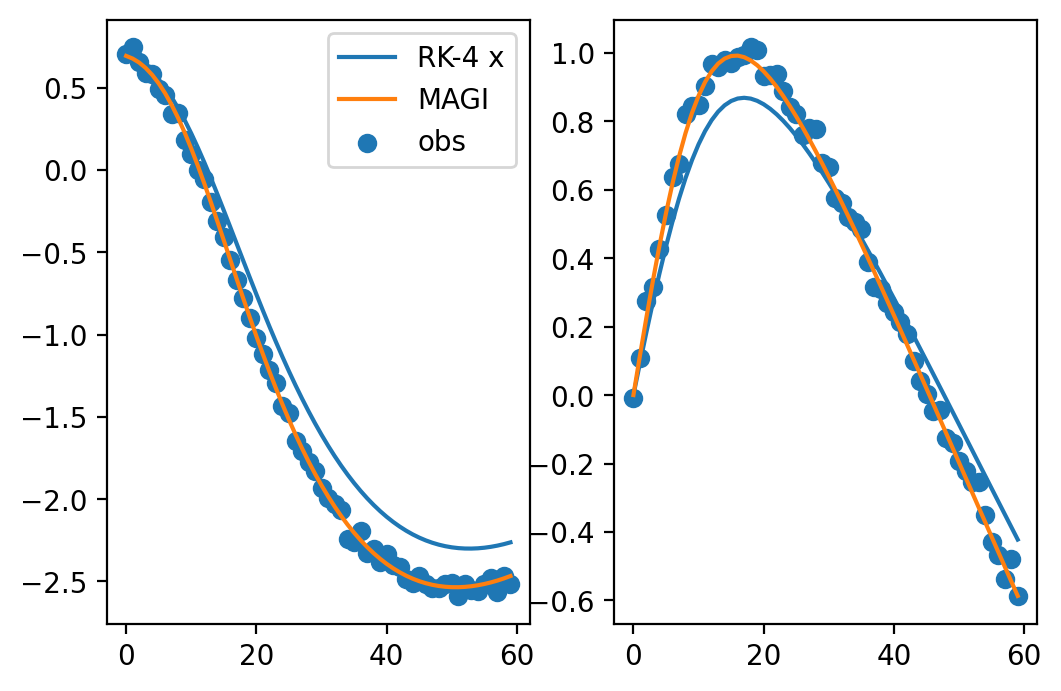

In [14]:
plt.rcParams['figure.dpi'] = 200 #分辨率
discretization=1
days = 5
obs_per_day=12
alpha1 = 0.6578
beta1 = 0.7926
delta1 = 0.8323
gamma1 = np.concatenate((0.5323 * np.ones(200000), 0.5323 * np.ones(200000)))
yobs_np = gen_data(alpha0, beta0, delta0, gamma0, days, obs_per_day)
x_true = gen_data(alpha0, beta0, delta0, gamma0, days, obs_per_day, noise=0)
x_reconstructed = gen_data(alpha1, beta1, delta1, gamma1, days, obs_per_day, state0 = [2., 1.], noise=0)

plt.subplot(1,2,1)
plt.scatter(np.arange(0, 60, 1), yobs_np[:, 0], label='obs')
plt.plot(x_reconstructed[:, 0], label='RK-4 x')
plt.plot(x_true[:, 0], label='MAGI')
# plt.plot(np.log(x2[::2]), label = 'inferred x')
# plt.plot(np.log(x_known[::2]), label = 'inferred x (known)')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(np.arange(0, 60, 1), yobs_np[:, 1], label='obs')
plt.plot(x_reconstructed[:, 1])
plt.plot(x_true[:, 1])
# plt.plot(np.log(x2[1::2]))
# plt.plot(np.log(x_known[1::2]), label = 'inferred x (known)')

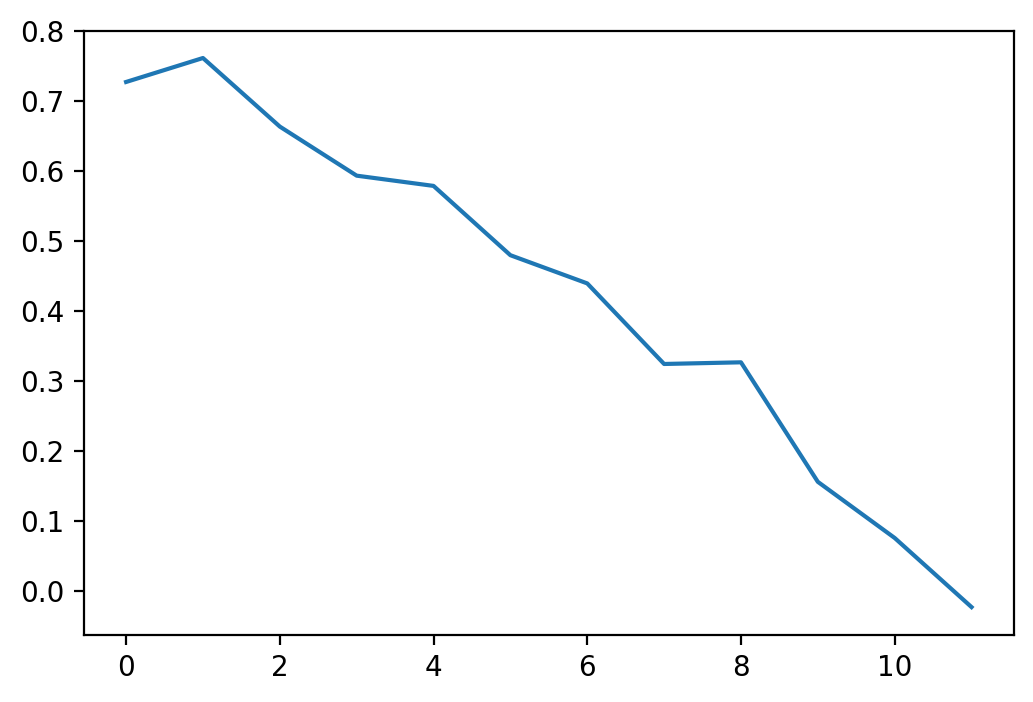

In [57]:
plt.plot(x_reconstructed[:, 0])

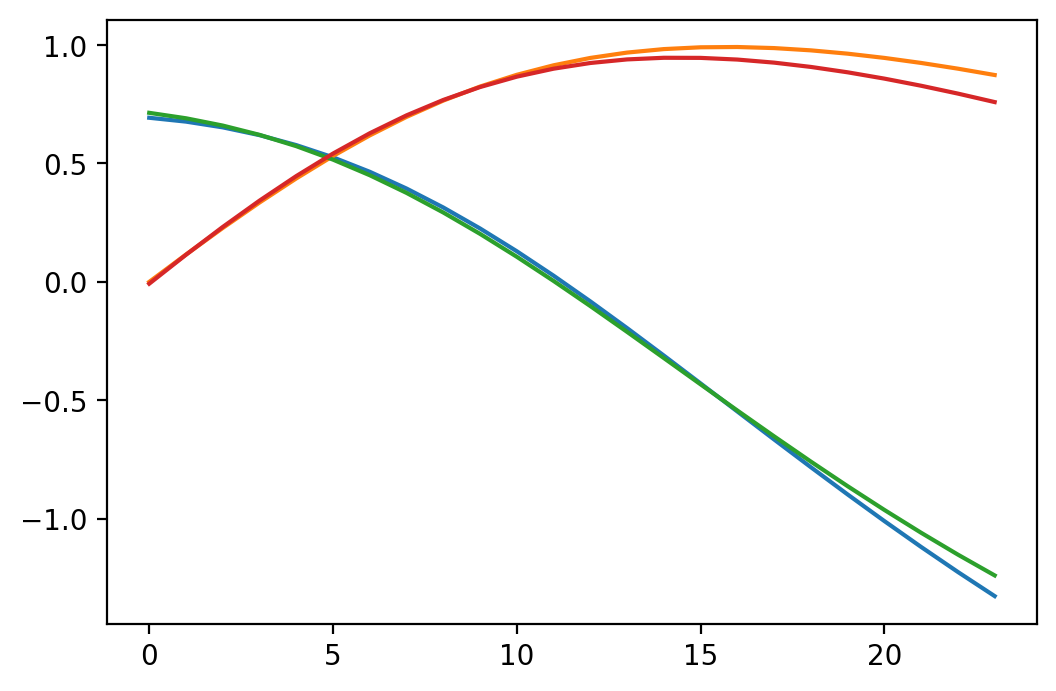

In [72]:
days = 2
gamma0 = np.concatenate((0.6 * np.ones(6000), 0.6 * np.ones(6000), 0.6 * np.ones(6000), 0.6 * np.ones(6000)))
gamma1 = np.concatenate((0.76320083 * np.ones(6000), 0.76320083 * np.ones(6000), 0.76320083 * np.ones(6000), 0.76320083 * np.ones(6000)))
yobs_np = gen_data(alpha0, beta0, delta0, gamma0, days, obs_per_day)
x_true = gen_data(alpha0, beta0, delta0, gamma0, days, obs_per_day, noise=0)
x_reconstructed = gen_data(alpha1, beta1, delta1, gamma1, days, obs_per_day, state0 = np.exp(inferred_trajectory[:, 0]), noise=0)
plt.plot(x_true)
plt.plot(x_reconstructed)

# Generate data, with multiple change points

In [15]:
import numpy as np
import torch
import scipy
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
from multiprocessing import Pool

%matplotlib inline
from IPython.core.pylabtools import figsize # import figsize



def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[2., 1.], linspace=100, noise=0.03, seed=5):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    np.random.seed(seed)
    states *= np.random.normal(1, noise, states.shape)
    return np.log(states)

def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = theta[0] - theta[1] * np.exp(fox)
    Fdt = theta[2] * np.exp(rabbit) - theta[3]
    return np.stack([Rdt, Fdt], axis=1)

def fOdeDx(theta, x):
    """
    returns ODE derivation of x given theta
    theta: list[4]
    x: array(n, 2)
    return: array(n, 2, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    resultDx = np.zeros(shape=[np.shape(x)[0], 2, 2])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dR
    resultDx[:, 0, 0] = 0
    # (0) / dF
    resultDx[:, 1, 0] =  -theta[1] * np.exp(fox)
    # (1) / dR
    resultDx[:, 0, 1] = theta[2] * np.exp(rabbit)
    # (1) / dF
    resultDx[:, 1, 1] = 0
    return resultDx

def fOdeDtheta(theta, x):
    """
    returns ODE derivation of theta given x
    theta: list[4]
    x: array(n, 2)
    return: array(n, 4, 2)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 4, 2])
    # [:, i, j]: jth equation derivative of the ith theta
    rabbit = x[:, 0]
    fox = x[:, 1]
    # (0) / 0
    resultDtheta[:, 0, 0] = 1.
    # (0) / 1
    resultDtheta[:, 1, 0] = -np.exp(fox)
    # (1) / 2
    resultDtheta[:, 2, 1] = np.exp(rabbit)
    # (1) / 3
    resultDtheta[:, 3, 1] = -1.
    return resultDtheta

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])


def construct(vals, occurence_times, history):
    ls = [history[int(np.sum(occurence_times)):]]
    for idx in range(occurence_times[0]):
        ls.append(torch.tensor([history[-1].item()]))
    for idx in range(occurence_times[1]):
        ls.append(vals[0])
    return torch.cat(ls, axis=0).reshape(-1, 1)


def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = constant_param_ls[0] - constant_param_ls[1] * torch.exp(fox)
    Fdt = constant_param_ls[2] * torch.exp(rabbit) - theta[:, 0]
    return torch.stack([Rdt, Fdt], axis=1)


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res), res.detach().numpy()


def new_likelihood(xlatent, vals, occurence_times, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, history):
    new_theta = construct(vals, occurence_times, history)
    return pointwisethetasigmallikTorch(xlatent, new_theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature)
    
    
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
torch.set_num_threads(1)
n_batch = 10
batch_size = 12
np.random.seed(5)
cp_val = np.random.binomial(1, 0.1, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
# construct gamma series

discretization=1
obs_per_day=12
total_days = int(5 + n_batch * batch_size / obs_per_day)
alpha0 = 0.6
beta0 = 0.75 
delta0 = 1. 
# 
MAGI_iter = 8000
gamma_ls = [0.6, 1.0]
gamma = 0.6 * np.ones(6000)
label = 0
for i in range(n_batch * batch_size):
    if cp_series[i]:
        label = 1-label
    val_tmp = gamma_ls[label]
    gamma = np.concatenate((gamma, val_tmp * np.ones(100)))  
    
yobs_np = gen_data(alpha0, beta0, delta0, gamma, total_days, obs_per_day)

# initiate parameters

theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
param_names = ['alpha', 'beta', 'delta', 'gamma']
is_time_varying=[False, False, False, True] 
use_trajectory='observation'
days = 5
yobs = yobs_np[:days * obs_per_day]
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])

# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=MAGI_iter,
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(MAGI_iter * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
    each_pycov = dict(
        Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
        Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
        mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
    )
    CovAllDimensionsPyList.append(each_pycov)
    
print(inferred_theta)
result_ls = []
history = torch.tensor(inferred_theta[3] * np.ones(days * obs_per_day))
# for each new batch
for EachBatch in range(n_batch):
#     theta_lowerbound=np.array([0., 0., 0., 0.])
#     theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
#     param_names = ['alpha', 'beta', 'delta', 'gamma']
#     is_time_varying=[False, False, False, True] 
#     use_trajectory='inferred'
#     days = 5
    
#     start_time = time.time()
#     nobs, p_dim = yobs.shape[0], yobs.shape[1]
#     n_points = nobs * discretization
#     theta_dim = theta_lowerbound.shape[0]
#     d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
#     for i in range(n_points):
#         for j in range(n_points):
#             if i > j:
#                 d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
#             else:
#                 d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
#     Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
#                              thetaLowerBound=theta_lowerbound,
#                              thetaUpperBound=theta_upperbound)
#     tvecObs = np.arange(0, days, 1. / obs_per_day)
#     tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
#     yFull = np.ndarray([n_points, p_dim])
#     yFull.fill(np.nan)
#     yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
#     xInitExogenous = np.zeros_like(yFull)
#     # interpolate: find the ydata of tvecFull given observations
#     for i in range(p_dim):
#         xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
#     # First stage: use MAGI package to optimize theta as constant
#     result = solve_magi(
#         yFull,
#         Ode_system,
#         tvecFull,
#         sigmaExogenous=np.array([]),
#         phiExogenous=np.array([[]]),
#         xInitExogenous=xInitExogenous,
#         thetaInitExogenous=np.array([]),
#         muExogenous=np.array([[]]),
#         dotmuExogenous=np.array([[]]),
#         priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
#         priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
#         priorTemperatureObs=1.0,
#         kernel="generalMatern",
#         nstepsHmc=100,
#         burninRatioHmc=0.5,
#         niterHmc=MAGI_iter,
#         stepSizeFactorHmc=0.01,
#         nEpoch=1,
#         bandSize=40,
#         useFrequencyBasedPrior=True,
#         useBand=False,
#         useMean=False,
#         useScalerSigma=False,
#         useFixedSigma=False,
#         verbose=True)
#     samplesCpp = result['samplesCpp']
#     llikId = 0
#     xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
#     # dimension of theta
#     thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
#     sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
#     burnin = int(MAGI_iter * 0.5)
#     xsampled = samplesCpp[xId, (burnin + 1):]
#     xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
#     CovAllDimensionsPyList = []
#     thetaSampled = samplesCpp[thetaId, (burnin + 1):]
#     inferred_theta_2 = np.mean(thetaSampled, axis=-1)
#     print(inferred_theta_2)
#     sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
#     inferred_sigma = np.mean(sigmaSampled, axis=-1)
#     inferred_trajectory = np.mean(xsampled, axis=-1)
#     for each_gpcov in result['result_solved'].covAllDimensions:
#         each_pycov = dict(
#             Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
#             Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
#             mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
#         )
#         CovAllDimensionsPyList.append(each_pycov)    
    yobs = yobs_np[int((EachBatch+1) * batch_size):int((EachBatch+1) * batch_size + days * obs_per_day)]
    sigma_torch = torch.tensor(inferred_sigma, dtype=torch.double)
    time_constant_param_ls = []
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == False:
            param_name = param_names[thetaEachDim]
            globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double) # 
            time_constant_param_ls.append(eval(param_name))
    ydata = torch.from_numpy(yobs).double()
    priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
    cur_loss = np.inf
    occurence_times = np.array([batch_size, 0])
    lik_ls = np.zeros(batch_size)
    val_ls = np.zeros(batch_size)
    truncate_pointwise_xlatent_torch_tmp = torch.tensor(ydata, requires_grad=True, dtype=torch.double)
    # try every time stamp
    for EachIter in range(batch_size):
        print(EachIter)
#         if EachIter in lik_ls.keys():
#             continue
        vals_tmp = torch.tensor(np.array([[1.]]), requires_grad=True)
        sigma_torch_tmp = sigma_torch.detach().clone()
        pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, vals_tmp]+ time_constant_param_ls, lr=1e-4)  #  , weight_decay = 1.0
        pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
        cur_loss_tmp = np.inf
        for epoch in range(100000):
            pointwise_optimizer.zero_grad()
            # compute loss function

            llik, res = new_likelihood(truncate_pointwise_xlatent_torch_tmp, vals_tmp, occurence_times, time_constant_param_ls, sigma_torch_tmp,
                                        ydata, CovAllDimensionsPyList, fOdeTorch, #    
                                        priorTemperature, history)
            new_loss = -llik
            if epoch % 1000 == 0:
                print(epoch, new_loss.item())
            if epoch % 200 == 0:
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                    break
                cur_loss_tmp = new_loss.item()
            new_loss.backward()
            pointwise_optimizer.step()
            pointwise_lr_scheduler.step()
        lik_ls[EachIter] = llik.item()
        val_ls[EachIter] = vals_tmp.detach().numpy()
        occurence_times[0] -= 1
        occurence_times[1] += 1
    print(lik_ls)
    print(time_constant_param_ls)
    # update history of gamma
    # change point not detected
    if max(lik_ls) - lik_ls[0] <= 2.:
        # update history
        print('No change point!')
        history = construct(torch.tensor([history[-1]]), [batch_size, 0], history)[:, 0]
        # update psi and theta using entire observation up to date
        result_ls.append(0)
    else:
        idx = np.argmax(lik_ls)
        print('Change point: ', 60 + batch_size - idx + EachBatch * batch_size)
        history = construct(torch.tensor([[val_ls[idx]]]), [batch_size-idx, idx], history)[:, 0]
        print(history)
        result_ls.append(1)

[0.58080476 0.73562382 1.00567175 0.60036679]
0
0 115309.80133809545


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:374: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1000 524.0071900064845
2000 -261.0133690086491
3000 -340.8263913508779
4000 -346.5923815313689
5000 -347.0005537302186
6000 -347.1207937650456
7000 -347.2721724967706
8000 -347.4519831010495
9000 -347.63756208732855
10000 -347.8020479983129
11000 -347.8792254833242
12000 -347.95538603664056
13000 -348.0162280163901
1
0 -214.0404770402447
1000 -333.93485517582576
2000 -338.8039861182973
3000 -342.73267924307515
4000 -345.4794858503176
5000 -347.104124926527
6000 -347.5931009796668
7000 -347.9034389419886
8000 -348.0476749552902
2
0 610.9538269497416
1000 -323.2712829994554
2000 -327.13403955026024
3000 -331.35882987072654
4000 -335.18680550683143
5000 -338.59063627500063
6000 -340.3899846328527
7000 -342.34018044059144
8000 -344.1891897922933
9000 -345.71824422287864
10000 -346.83389891909474
11000 -347.2557576508223
12000 -347.5932844351863
13000 -347.8305273377796
14000 -347.97282413426535
15000 -348.0399230661429
3
0 1583.5761961818262
1000 -310.4723267807664
2000 -316.67585119309535

In [13]:
result_ls

[0, 0, 0, 1, 1, 1, 0, 1, 1, 1]

In [20]:
n_batch = 10
batch_size = 12
np.random.seed(5)
cp_val = np.random.binomial(1, 0.1, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
cp_val

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

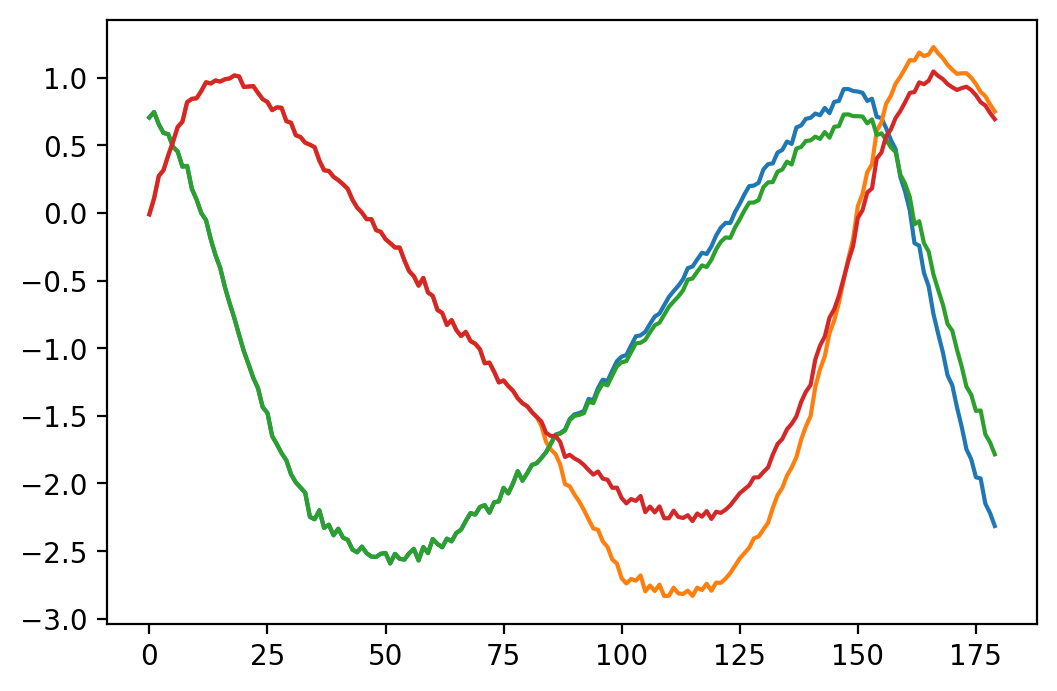

In [3]:
import numpy as np
import torch
import scipy
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
from multiprocessing import Pool

%matplotlib inline
from IPython.core.pylabtools import figsize # import figsize



def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[2., 1.], linspace=100, noise=0.03, seed=5):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    np.random.seed(seed)
    states *= np.random.normal(1, noise, states.shape)
    return np.log(states) 
    
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
torch.set_num_threads(1)
n_batch = 10
batch_size = 12
np.random.seed(5)
cp_val = np.random.binomial(1, 0.2, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
# construct gamma series

discretization=1
obs_per_day=12
total_days = int(5 + n_batch * batch_size / obs_per_day)
alpha0 = 0.6
beta0 = 0.75 
delta0 = 1. 
# 
MAGI_iter = 8000
gamma_ls = [0.6, 1.0]
gamma = 0.6 * np.ones(6000)
label = 0
for i in range(n_batch * batch_size):
    if cp_series[i]:
        label = 1-label
    val_tmp = gamma_ls[label]
    gamma = np.concatenate((gamma, val_tmp * np.ones(100)))  
    
gamma_prime = 0.6 * np.ones(1000000)
yobs_np = gen_data(alpha0, beta0, delta0, gamma, total_days, obs_per_day)
yobs_np_prime = gen_data(alpha0, beta0, delta0, gamma_prime, total_days, obs_per_day)
plt.plot(yobs_np)
plt.plot(yobs_np_prime)

In [4]:
cp_series

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [7]:
history

ls = [history[:-12]]
for idx in range(occurence_times[0]):
    ls.append(torch.tensor([history[-1].item()]))
for idx in range(occurence_times[1]):
    ls.append(vals_tmp[0])
torch.cat(ls, axis=0).reshape(-1, history.shape[0])

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [24]:
inferred_trajectory

array([[-2.46522603, -2.44483753, -2.42344485, -2.40100762, -2.37763101,
        -2.35331481, -2.32809588, -2.30204688, -2.27514336, -2.24748899,
        -2.21907003, -2.18991343, -2.16011297, -2.12957296, -2.09836475,
        -2.06650615, -2.0340883 , -2.00104067, -1.967401  , -1.93332706,
        -1.89862436, -1.86346156, -1.82779648, -1.7916436 , -1.75507323,
        -1.7180559 , -1.68060777, -1.64277645, -1.60456416, -1.56598091,
        -1.52704181, -1.48780899, -1.4481823 , -1.40824423, -1.36801822,
        -1.32746601, -1.28664424, -1.24557636, -1.20419972, -1.16259879,
        -1.12074941, -1.07867248, -1.03634503, -0.99382427, -0.95110844,
        -0.90818121, -0.86502695, -0.8216822 , -0.77816496, -0.73446655,
        -0.69057594, -0.64655467, -0.60237395, -0.55803404, -0.51355499,
        -0.46893952, -0.42418072, -0.37929857, -0.33438825, -0.28924474],
       [-0.66655395, -0.70423093, -0.74189977, -0.7795485 , -0.817193  ,
        -0.85485203, -0.89245662, -0.93009169, -0.

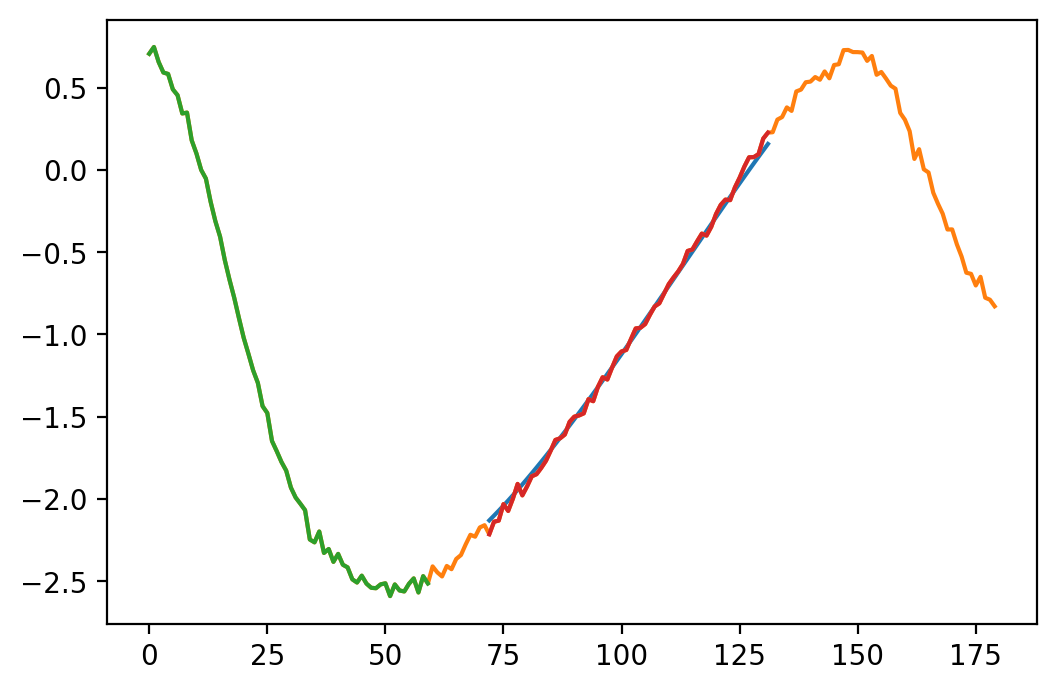

In [12]:
plt.plot(np.arange(72, 132, 1), truncate_pointwise_xlatent_torch_tmp.detach().numpy()[:, 0])

plt.plot(yobs_np[:, 0])
plt.plot(yFull[:, 0])
plt.plot(np.arange(72, 132, 1), yobs[:, 0])
# plt.plot(truncate_pointwise_xlatent_torch_tmp.detach().numpy()[:, 1])
# plt.plot(yobs[:, 1])

In [4]:
n_batch = 50
batch_size = 12
np.random.seed(5)
cp_val = np.random.binomial(1, 0.1, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
for i in range(50):
    print(cp_series[i * 12:i * 12 + 12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0.

Text(0.5, 1.0, 'Detected Change Point = 104')

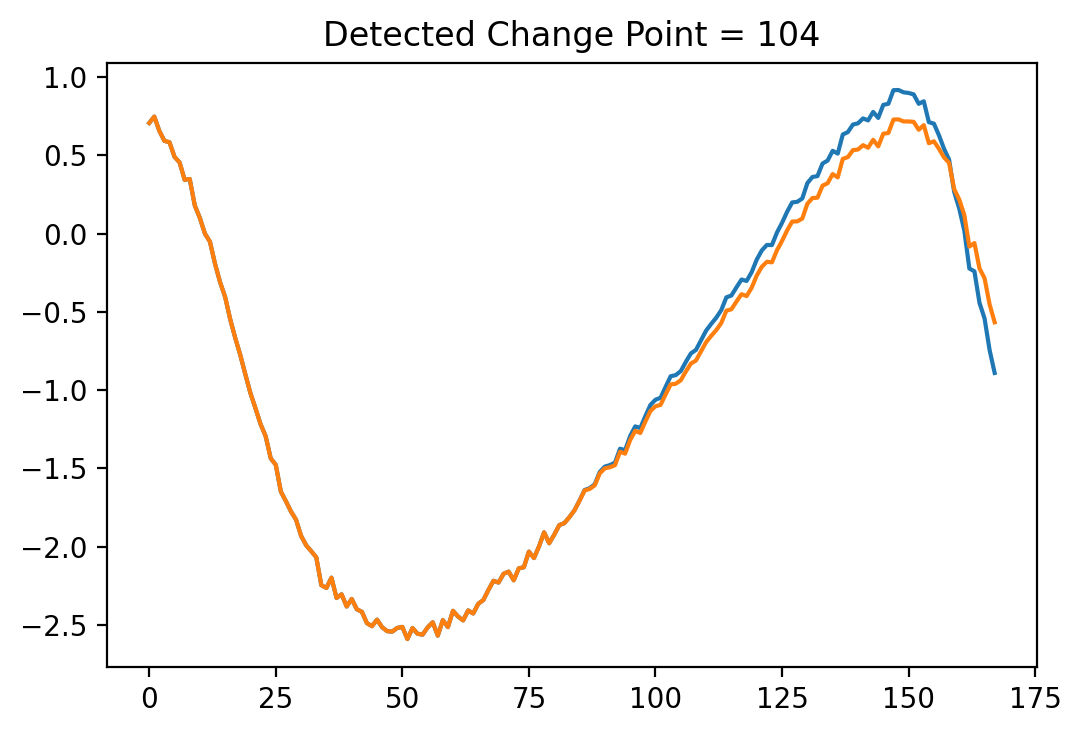

In [13]:
n_batch = 9
batch_size = 12

np.random.seed(5)
cp_val = np.random.binomial(1, 0.2, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
        
discretization=1
obs_per_day=12
total_days = int(5 + n_batch * batch_size / obs_per_day)
alpha0 = 0.6
beta0 = 0.75 
delta0 = 1. 
# 
MAGI_iter = 8000
gamma_ls = [0.6, 1.0]
gamma = 0.6 * np.ones(6000)
label = 0
for i in range(n_batch * batch_size):
    if cp_series[i]:
        label = 1-label
    val_tmp = gamma_ls[label]
    gamma = np.concatenate((gamma, val_tmp * np.ones(100)))  
    
yobs_np = gen_data(alpha0, beta0, delta0, gamma, total_days, obs_per_day)



plt.plot(yobs_np[:, 0])
# plt.plot(yobs_np[:, 1])
gamma2 = 0.6 * np.ones(1000000)
yobs_np2 = gen_data(alpha0, beta0, delta0, gamma2, total_days, obs_per_day)
plt.plot(yobs_np2[:, 0])
len(yobs_np2)
plt.title('Detected Change Point = 104')

# Partial code

In [7]:
ydata = torch.from_numpy(yFull).double()

history = torch.tensor(0.6 * np.ones(48))
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1
pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)

tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == False:
        param_name = param_names[thetaEachDim]
        globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double) # 
        time_constant_param_ls.append(eval(param_name))

priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
cur_loss = np.inf
occurence_times = np.array([12, 0])
lik_ls = np.zeros(12)
val_ls = np.zeros(12)
# try every time stamp
for EachIter in range(12):
    print(EachIter)
#         if EachIter in lik_ls.keys():
#             continue
    vals_tmp = torch.tensor(np.array([[inferred_theta[3]]]), requires_grad=True)
    truncate_pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()
    truncate_pointwise_xlatent_torch_tmp.requires_grad = True
    sigma_torch_tmp = sigma_torch.detach().clone()
    pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, vals_tmp] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
    pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
    cur_loss_tmp = np.inf
    for epoch in range(100000):
        pointwise_optimizer.zero_grad()
        # compute loss function

        llik, res = new_likelihood(truncate_pointwise_xlatent_torch_tmp, vals_tmp, occurence_times, time_constant_param_ls, sigma_torch_tmp,
                                    ydata, CovAllDimensionsPyList, fOdeTorch, #    
                                    priorTemperature, history)
        new_loss = -llik
        if epoch % 200 == 0:
            print(epoch, new_loss.item())
            diff = new_loss.item() - cur_loss_tmp
            if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                break
            cur_loss_tmp = new_loss.item()
        new_loss.backward()
        pointwise_optimizer.step()
        pointwise_lr_scheduler.step()
    lik_ls[EachIter] = llik.item()
    val_ls[EachIter] = vals_tmp.detach().numpy()
    occurence_times[0] -= 1
    occurence_times[1] += 1
print(lik_ls)
# update history of gamma
# change point not detected
if max(lik_ls) - lik_ls[0] <= 3.84:
    # update history
    print('No change point!')
    history = construct(torch.tensor([history[-1]]), [12, 0], history)
else:
    idx = np.argmax(lik_ls)
    print('Change point: ', batch_size - idx + EachBatch * batch_size)
    history = construct(torch.tensor([val_ls[idx]]), [12-idx, idx], history)

0
0 6571.999635979358
200 5970.55200686959
400 5447.9569388777245
600 4958.226757846603
800 4500.646888280952
1000 4074.4103195247862
1200 3678.0998940666627
1400 3310.113929378733
1600 2968.8297573176396
1800 2652.669471094792
2000 2360.1282001674135
2200 2089.787467982998
2400 1840.320071505113
2600 1610.4929168960252
2800 1399.1687261674563
3000 1205.2998744698089


KeyboardInterrupt: 

In [5]:
time_constant_param_ls

[tensor([0.5792], dtype=torch.float64, requires_grad=True),
 tensor([0.6806], dtype=torch.float64, requires_grad=True),
 tensor([0.0963], dtype=torch.float64, requires_grad=True)]

In [41]:
torch.cat([torch.tensor([1,2,3]), torch.tensor([1]),torch.tensor([2])], axis=0)

tensor([1, 2, 3, 1, 2])

In [43]:
a = torch.tensor([1,2,3])
torch.tensor([a[-1]])

tensor([3])

In [16]:
a = [1,2,3,2,1]
a.sort()
a

[1, 1, 2, 2, 3]